## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-outdoor' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'green'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
green_diagonal_wavelet_outdoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/diagonal/green'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 2006,
 3: 8024,
 4: 32096,
 5: 128384,
 6: 513536,
 7: 2054144,
 8: 8216576,
 9: 32866304}

Running 12760 CDFs


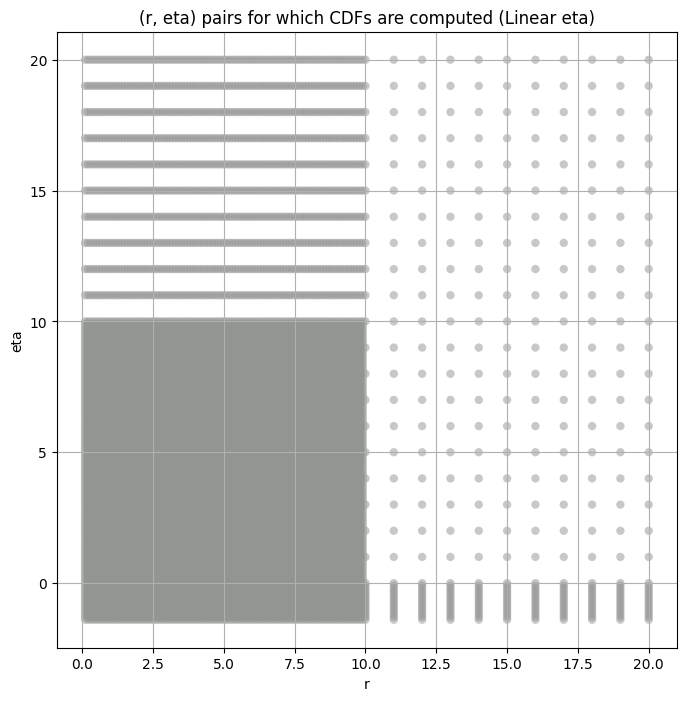

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1275.482800  1122.617700  1438.783600   2.691186    1.650079   
3       278.655100   260.725000   297.130300   3.187759    2.693464   
4        59.196210    55.125656    63.416320   5.437293    4.557088   
5        11.759620    10.812905    12.747702   8.242884    6.854574   
6         2.387361     2.172065     2.619214  11.316391    9.004839   
7         0.550675     0.498310     0.607436  12.836428    9.904830   
8         0.193843     0.175944     0.213105  11.674941    8.750526   
9         0.094923     0.086730     0.103822  10.211844    7.322517   

       kurt_upper  total_samples  
layer                             
2        4.078578         2006.0  
3        3.752663         8024.0  
4        6.545280        32096.0  
5       10.175736       128384.0  
6       14.718013       513536.0  
7       17.388290      2054144.0  
8       17.741255      8216576.0  
9       15.754383     32866304.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      1275.482800    1275.482788      947.983643      776.812195   
3       278.655100     278.655090      248.473984      229.237930   
4        59.196210      59.196209       56.233189       54.199978   
5        11.759620      11.759620       11.444755       11.217157   
6         2.387361       2.387361        2.303447        2.246751   
7         0.550675       0.550675        0.528636        0.514333   
8         0.193843       0.193843        0.186362        0.181549   
9         0.094923       0.094923        0.091308        0.089042   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2          658.250183       565.633667       432.221985       340.251404   
3          213.747086       200.615509       178.463684       160.749283   
4           52.485645        50.953655        48.281914        45.980343   
5           11.019105        10.839754        10.521185        10.238976   
6            2.198928         2.156558         2.082155         2.017048   
7            0.502395         0.491873         0.473505         0.457579   
8            0.177541         0.173998         0.167820         0.162470   
9            0.087160         0.085506         0.082646         0.080197   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2           269.926208       216.115662       172.906662        83.633293  
3           146.206802       133.558990       122.450966        96.370033  
4            43.936470        42.086369        40.404854        36.146687  
5             9.983467         9.748548         9.529944         8.949634  
6             1.958365         1.904597         1.854762         1.724314  
7             0.443405         0.430517         0.418689         0.387915  
8             0.157705         0.153386         0.149426         0.139147  
9             0.078035         0.076091         0.074322         0.069791

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.010002616277218879 1275.4828


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.022362519528628444 947.98364


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.033606561940807356 776.8122


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.045334942082058016 658.2502


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.05708571703601828 565.63367


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.07919915577014325 432.222


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.10169863331237422 340.2514


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.12249977381372568 269.9262


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.14420417410027575 216.11566


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.164941582904074 172.90666


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.22737368420036264 83.63329
Number of samples: 2006, Without approximation : 2006.0


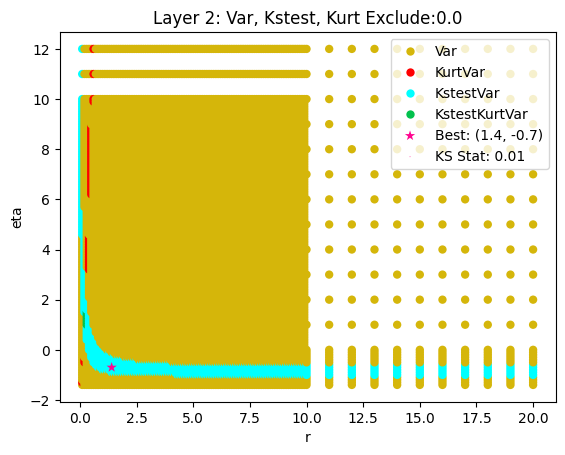

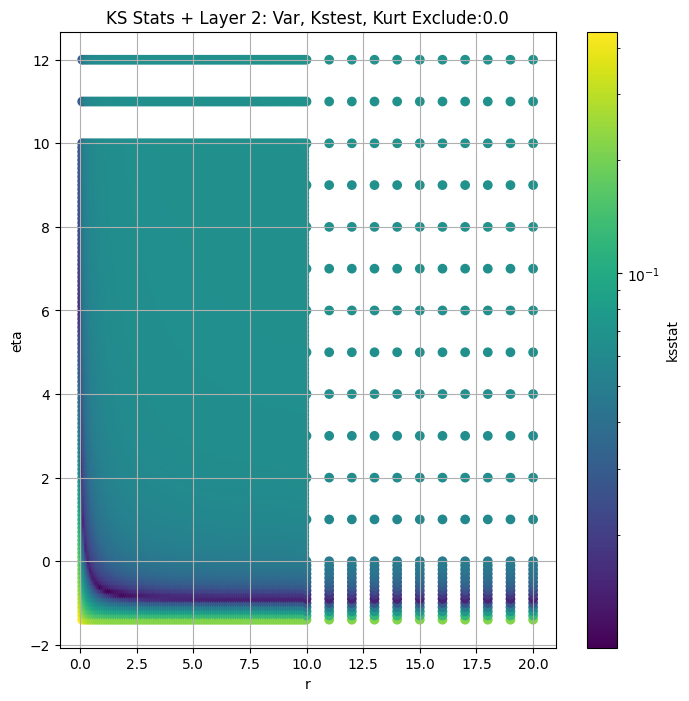

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.014405893822182159 278.6551


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.014550806972856156 248.47398


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.01470525607208062 229.23793


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.015752392849122755 213.74709


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.019723469028079213 200.61551


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.026542447423393983 178.46368


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.033426995775341126 160.74928


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.040099490425307485 146.2068


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.04649928891342439 133.55899


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.05284531943206695 122.450966


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.07036082087527716 96.37003
Number of samples: 8024, Without approximation : 8024.0


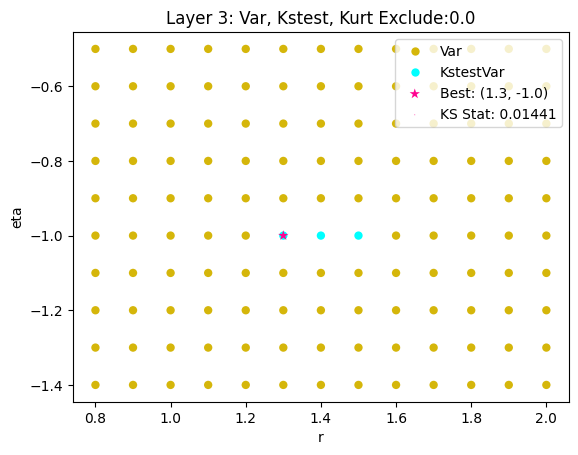

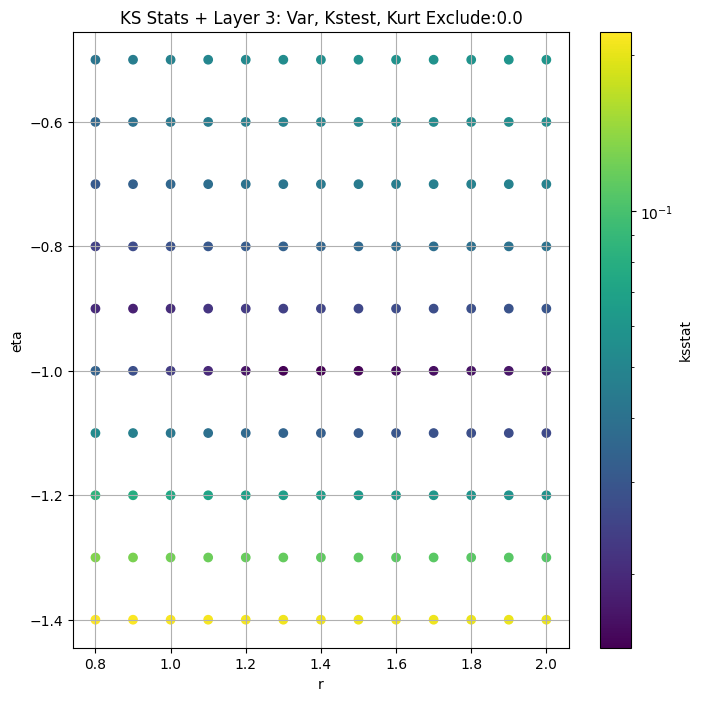

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.018725074775672867 59.19621


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.018725074775672867 56.23319


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.018725074775672867 54.199978


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.018725074775672867 52.485645


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.018725074775672867 50.953655


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.018725074775672867 48.281914


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.018725074775672867 45.980343


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.018725074775672867 43.93647


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.018725074775672867 42.08637


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.01872507477567309 40.404854


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.021750204592449154 36.146687
Number of samples: 32096, Without approximation : 32096.0


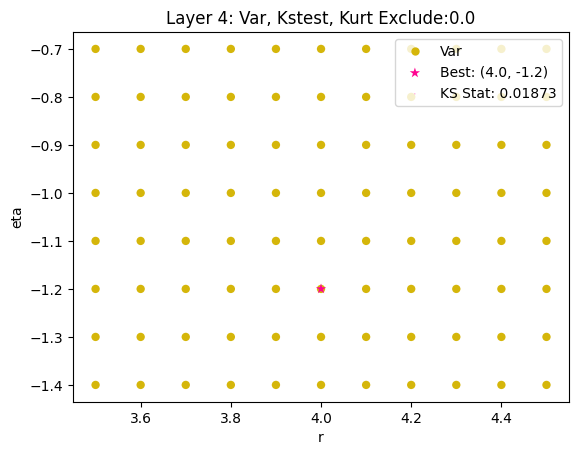

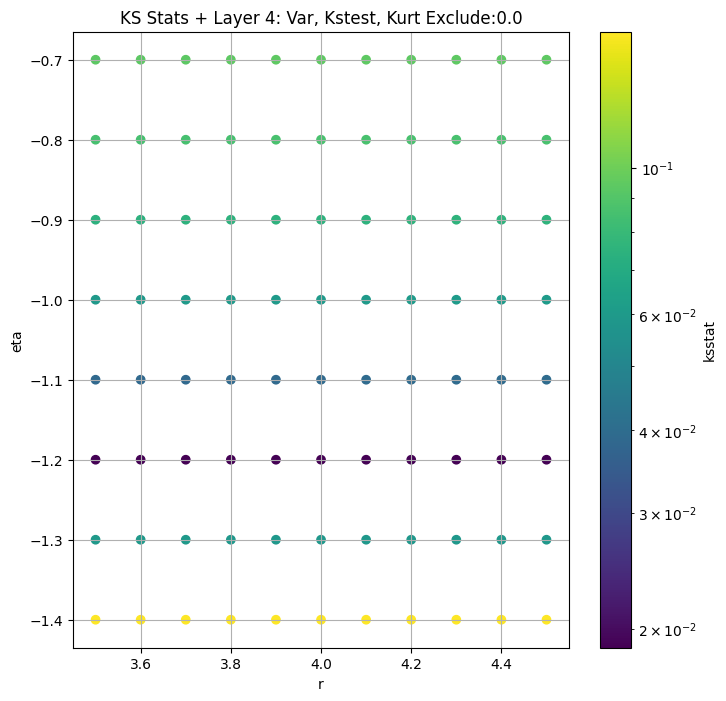

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.03986999999999974 11.75962


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.03986999999999974 11.444755


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.03986999999999974 11.217157


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.03986999999999974 11.019105


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.03986999999999974 10.839754


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.03986999999999974 10.521185


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.03986999999999974 10.2389765


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.03986999999999974 9.983467


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.03986999999999974 9.748548


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.03986999999999974 9.529944


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.03986999999999974 8.949634
Number of samples: 100000, Without approximation : 128384.0


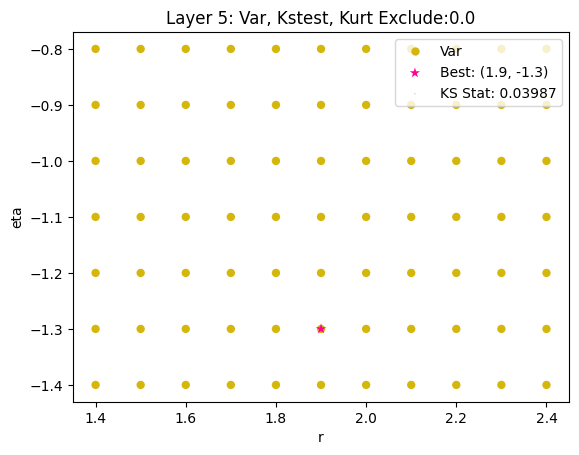

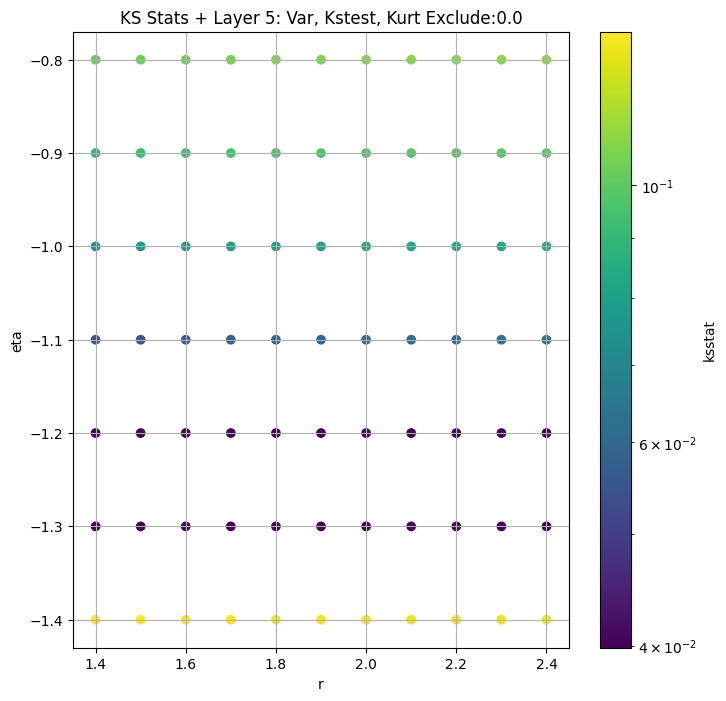

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.0771799999999998 2.3873613


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.0771799999999998 2.3034468


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.0771799999999998 2.2467508


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.0771799999999998 2.1989279


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.0771799999999998 2.1565578


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.0771799999999998 2.0821555


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.0771799999999998 2.017048


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.0771799999999998 1.9583646


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.0771799999999998 1.9045968


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.0771799999999998 1.8547624


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.0771799999999998 1.7243137
Number of samples: 100000, Without approximation : 513536.0


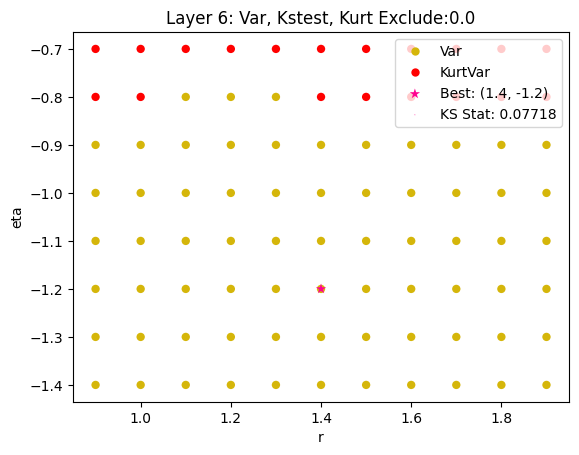

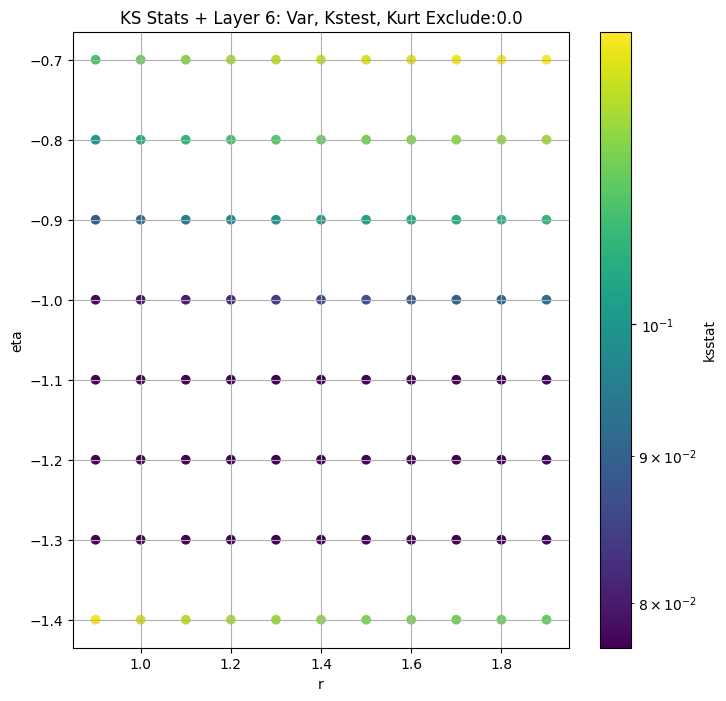

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.12073999999999974 0.5506746


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.12073999999999974 0.52863646


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.12073999999999974 0.51433307


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.12073999999999974 0.50239545


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.12073999999999974 0.49187306


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.12073999999999974 0.4735048


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.12073999999999974 0.4575789


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.12073999999999974 0.44340524


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.12073999999999974 0.43051726


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.12073999999999974 0.41868898


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.12073999999999974 0.3879155
Number of samples: 100000, Without approximation : 2054144.0


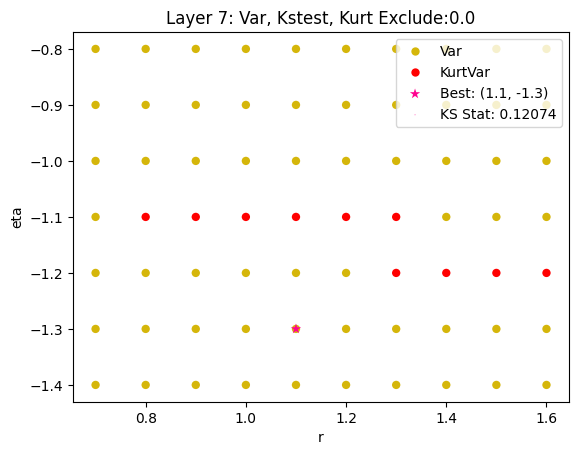

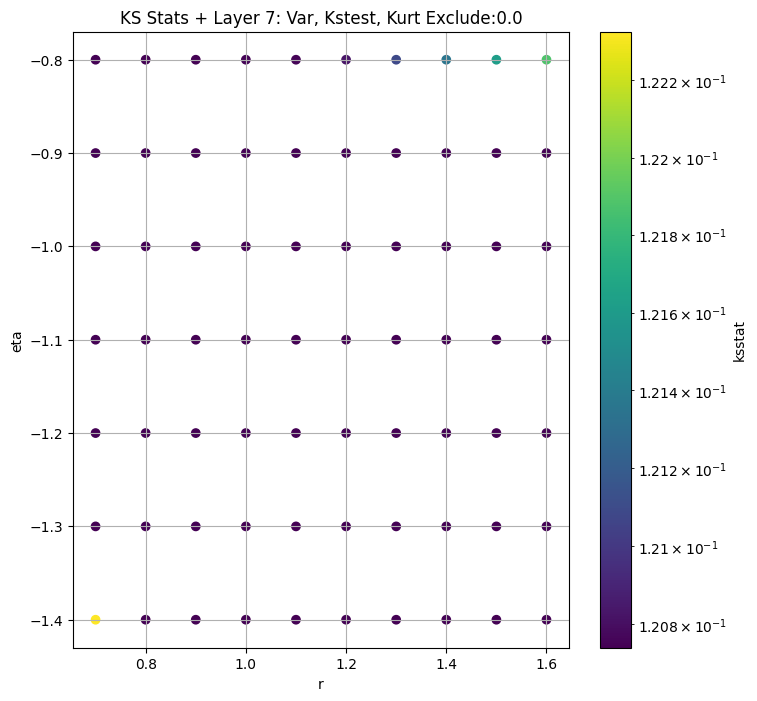

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.16338000000000003 0.1938427


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.16338000000000003 0.18636182


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.16338000000000003 0.18154936


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.16338000000000003 0.1775409


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.16338000000000003 0.17399827


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.16338000000000003 0.16782047


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.16338000000000003 0.16247042


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.16338000000000003 0.15770498


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.16338000000000003 0.15338616


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.16338000000000003 0.14942603


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.16338000000000003 0.13914669
Number of samples: 100000, Without approximation : 8216576.0


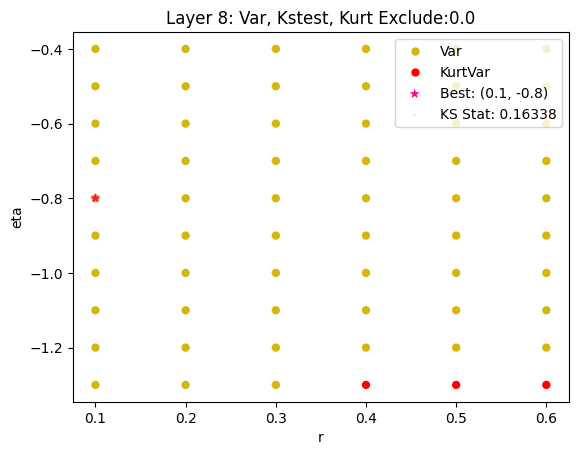

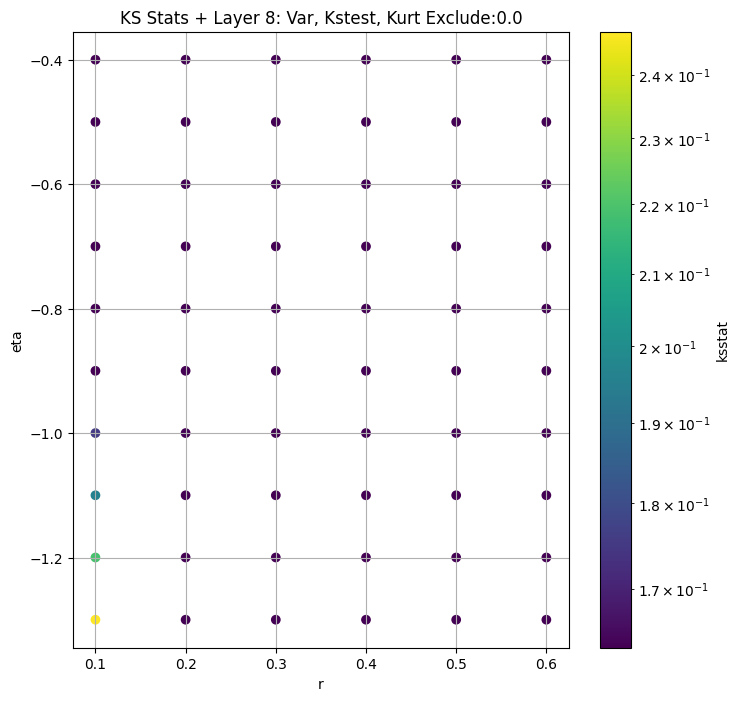

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.20730999999999977 0.0949234


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.20730999999999977 0.09130849


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.20730999999999977 0.08904166


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.20730999999999977 0.08715992


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.20730999999999977 0.085506216


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.20730999999999977 0.082646415


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.20730999999999977 0.080196716


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.20730999999999977 0.078035384


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.20730999999999977 0.07609132


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.20730999999999977 0.07432207


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.20730999999999977 0.069791086
Number of samples: 100000, Without approximation : 32866304.0


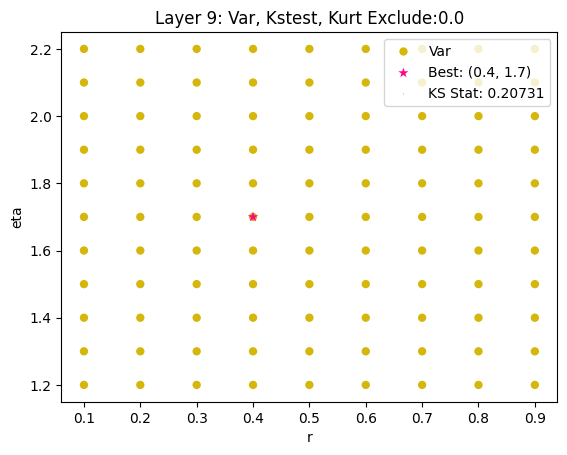

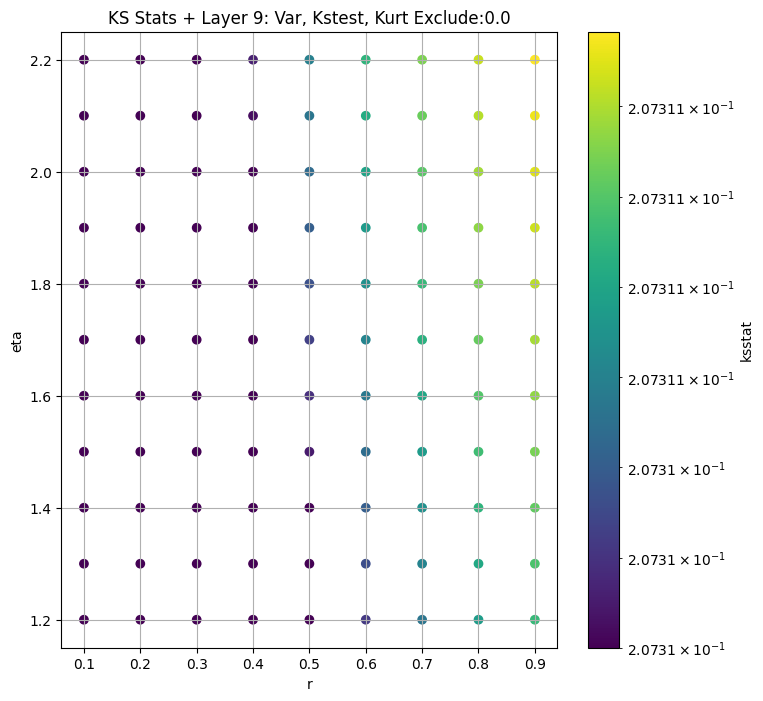

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1275.482800  1122.617700  1438.783600   2.691186    1.650079   
3       278.655100   260.725000   297.130300   3.187759    2.693464   
4        59.196210    55.125656    63.416320   5.437293    4.557088   
5        11.759620    10.812905    12.747702   8.242884    6.854574   
6         2.387361     2.172065     2.619214  11.316391    9.004839   
7         0.550675     0.498310     0.607436  12.836428    9.904830   
8         0.193843     0.175944     0.213105  11.674941    8.750526   
9         0.094923     0.086730     0.103822  10.211844    7.322517   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.078578         2006.0             0.010003        1.4         -0.7   
3        3.752663         8024.0             0.014406        1.3         -1.0   
4        6.545280        32096.0             0.018725        4.0         -1.2   
5       10.175736       128384.0             0.039870        1.9         -1.3   
6       14.718013       513536.0             0.077180        1.4         -1.2   
7       17.388290      2054144.0             0.120740        1.1         -1.3   
8       17.741255      8216576.0             0.163380        0.1         -0.8   
9       15.754383     32866304.0             0.207310        0.4          1.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       2.209447e+03                     0.0         1275.482800   
3       6.906262e+02                     0.0          278.655100   
4       2.760058e+02                     0.0           59.196210   
5       7.462944e+01                     0.0           11.759620   
6       9.734533e+00                     0.0            2.387361   
7       2.927620e+00                     0.0            0.550675   
8       6.670561e-12                     0.0            0.193843   
9       4.221504e-04                     0.0            0.094923   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.030238  
3                     0.015140  
4                     0.007575  
5                     0.003789  
6                     0.001895  
7                     0.000947  
8                     0.000474  
9                     0.000237

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.061393517514348794, var: 565.6336669921875


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.04746068184259311, var: 658.2501831054688


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.0350825011476712, var: 776.8121948242188


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.023772925038863968, var: 947.983642578125


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.009599031162627614, var: 1275.4827880859375
Number of samples: 2006, Without approximation : 2006.0


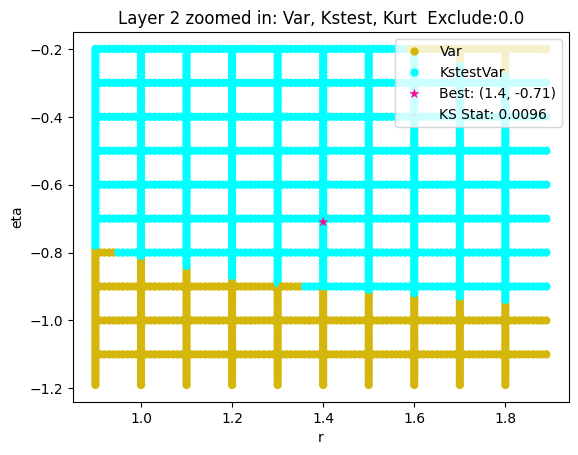

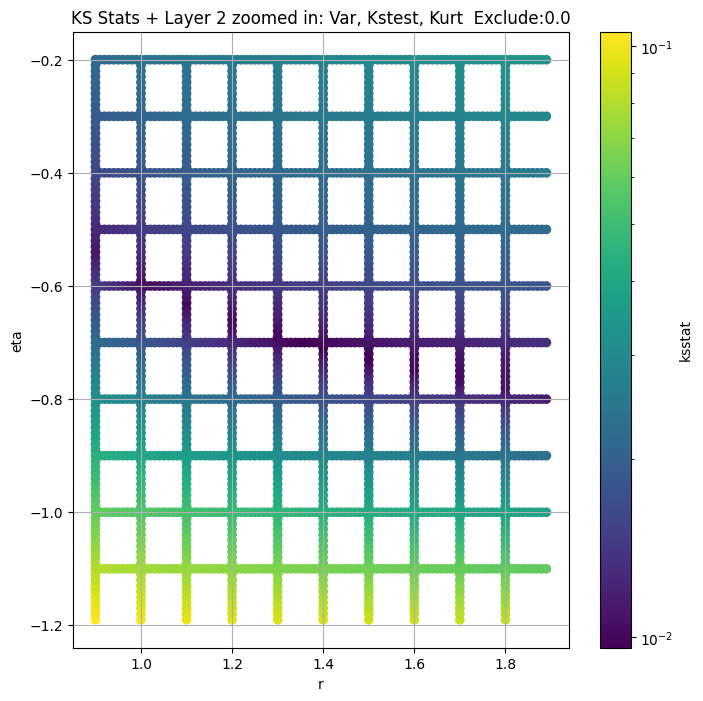

Layer 3


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.02328196881093661, var: 200.61550903320312


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.02006596815386441, var: 213.74708557128906


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.01719475542441848, var: 229.23793029785156


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.014537343127386637, var: 248.47398376464844


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.013726918795406218, var: 278.65509033203125
Number of samples: 8024, Without approximation : 8024.0


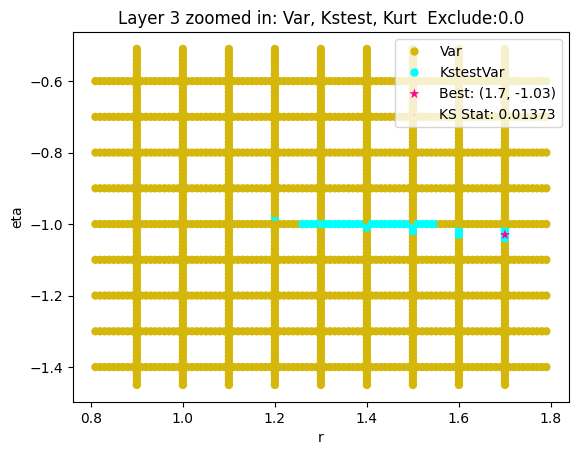

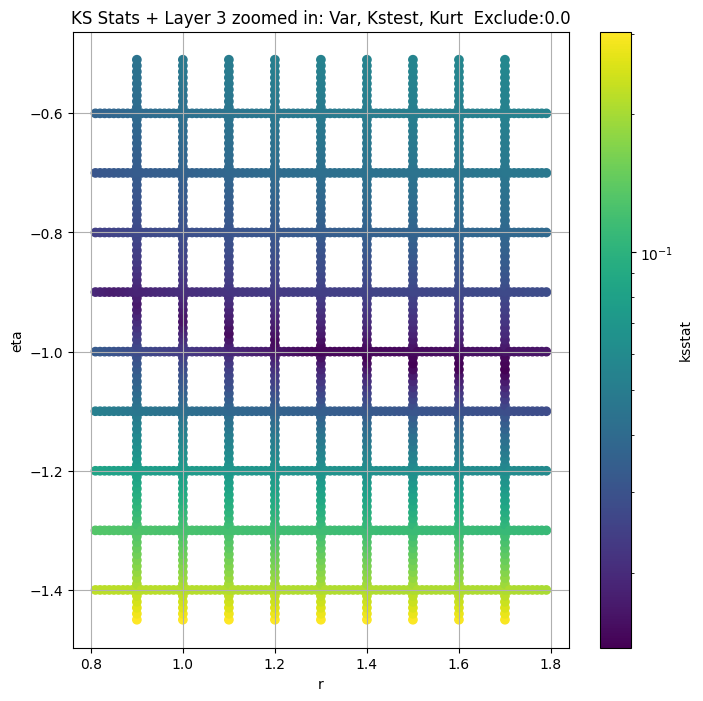

Layer 4


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.018725074775672867, var: 50.95365524291992


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.018725074775672867, var: 52.48564529418945


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.018725074775672867, var: 54.19997787475586


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.018725074775672867, var: 56.23318862915039


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.018725074775672867, var: 59.19620895385742
Number of samples: 32096, Without approximation : 32096.0


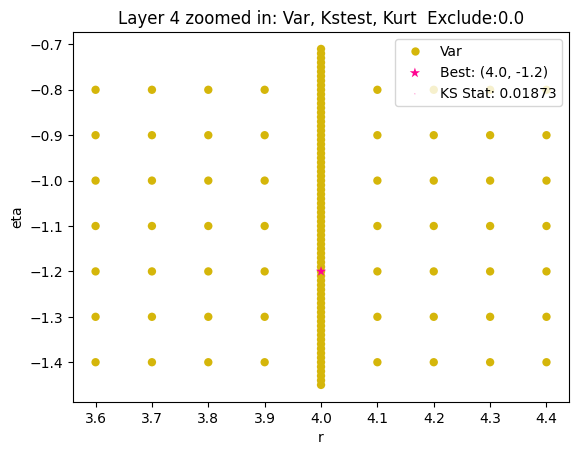

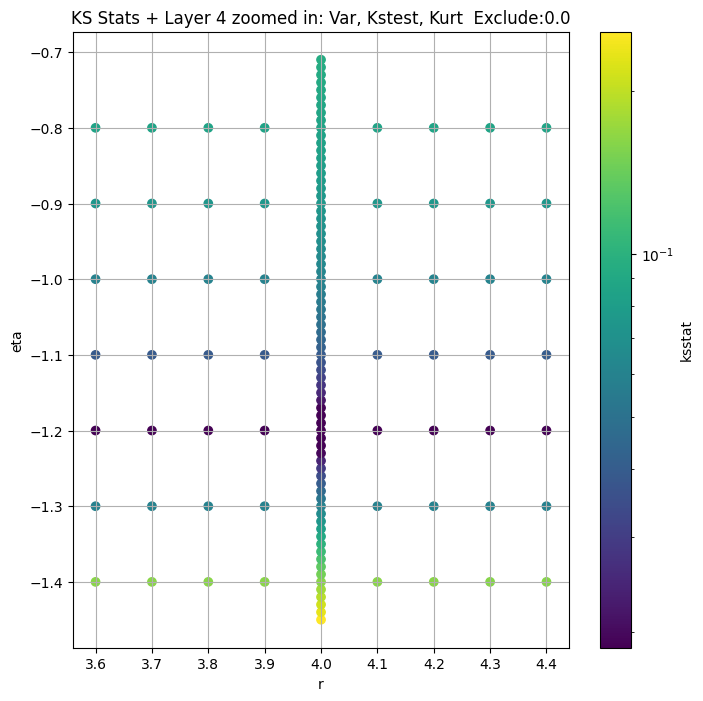

Layer 5


  0%|          | 0/732 [00:00<?, ?it/s]

Finding Minimum after computing 732 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.03986999999999974, var: 10.839754104614258


  0%|          | 0/732 [00:00<?, ?it/s]

Finding Minimum after computing 732 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.03986999999999974, var: 11.019104957580566


  0%|          | 0/732 [00:00<?, ?it/s]

Finding Minimum after computing 732 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.03986999999999974, var: 11.217157363891602


  0%|          | 0/732 [00:00<?, ?it/s]

Finding Minimum after computing 732 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.03986999999999974, var: 11.444754600524902


  0%|          | 0/732 [00:00<?, ?it/s]

Finding Minimum after computing 732 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.03986999999999974, var: 11.75961971282959
Number of samples: 100000, Without approximation : 128384.0


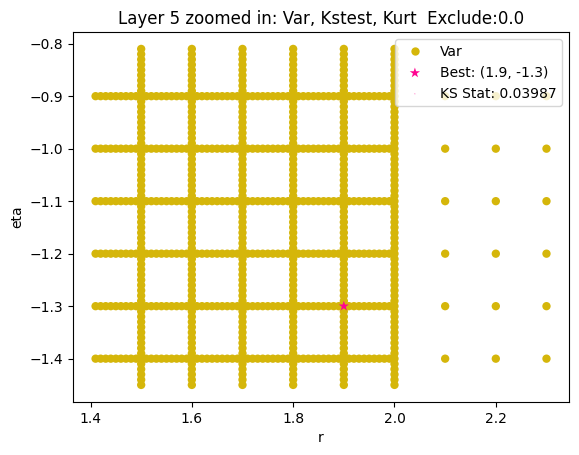

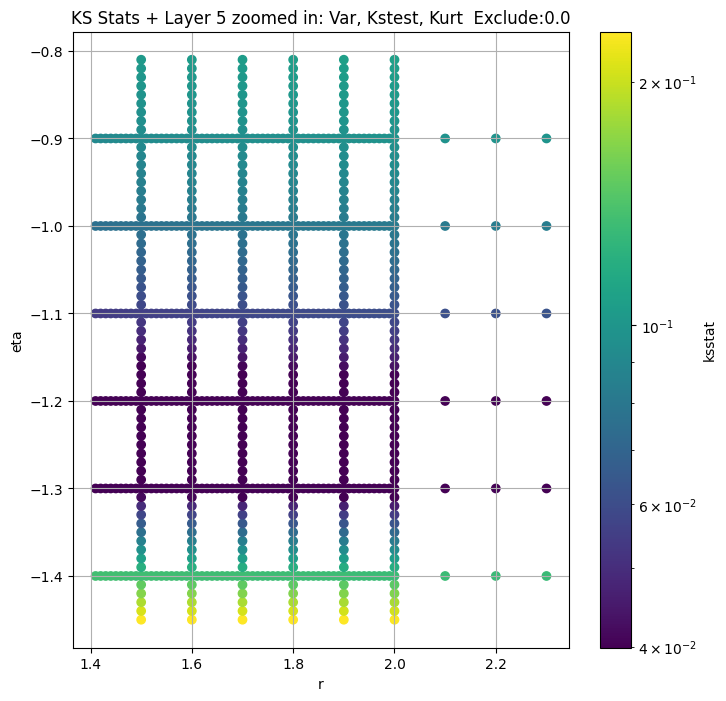

Layer 6


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.07717999999999975, var: 2.15655779838562


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.07717999999999975, var: 2.198927879333496


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.07717999999999975, var: 2.246750831604004


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.07717999999999975, var: 2.3034467697143555


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.07717999999999975, var: 2.3873612880706787
Number of samples: 100000, Without approximation : 513536.0


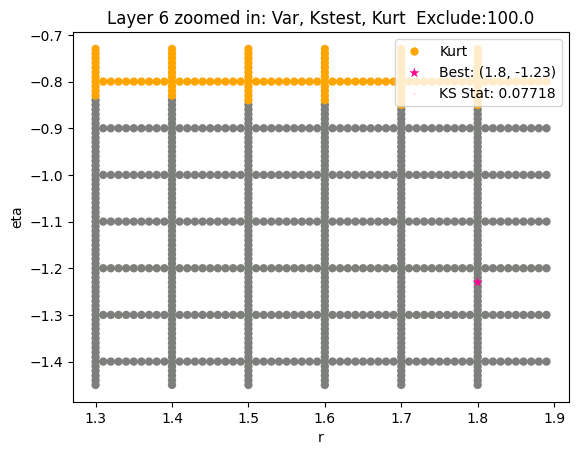

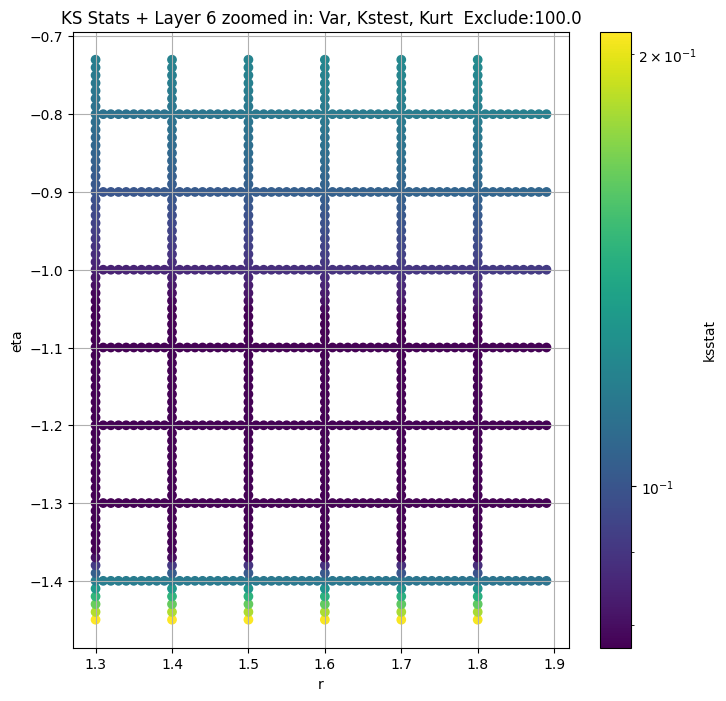

Layer 7


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.12073999999999974, var: 0.4918730556964874


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.12073999999999974, var: 0.5023954510688782


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.12073999999999974, var: 0.5143330693244934


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.12073999999999974, var: 0.5286364555358887


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.12073999999999974, var: 0.5506746172904968
Number of samples: 100000, Without approximation : 2054144.0


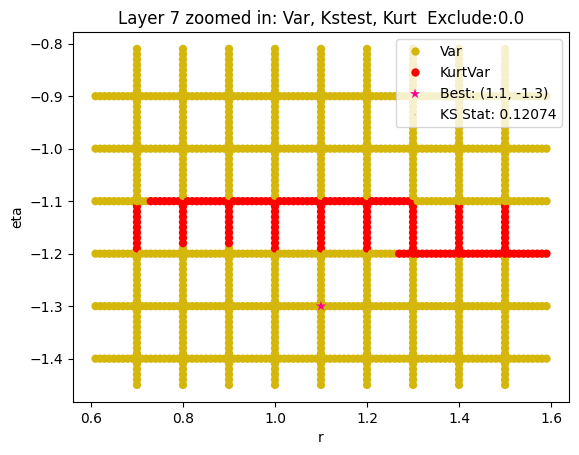

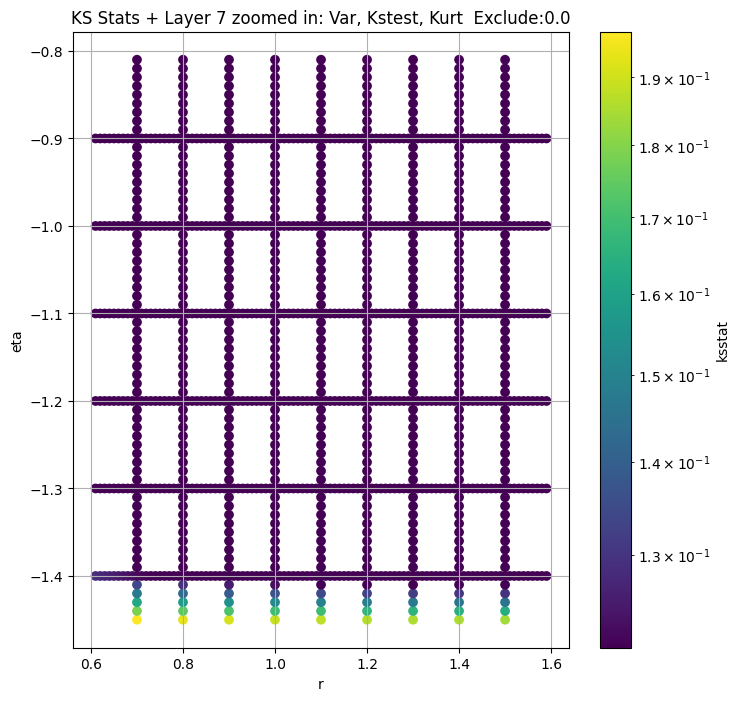

Layer 8


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.16338000000000003, var: 0.17399826645851135


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.16338000000000003, var: 0.17754089832305908


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.16338000000000003, var: 0.18154935538768768


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.16338000000000003, var: 0.18636181950569153


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.16338000000000003, var: 0.19384269416332245
Number of samples: 100000, Without approximation : 8216576.0


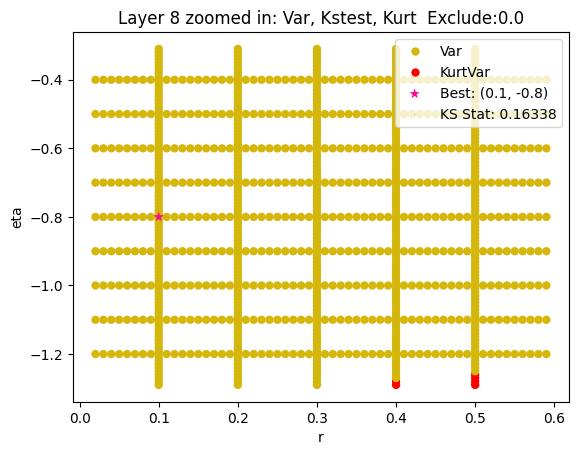

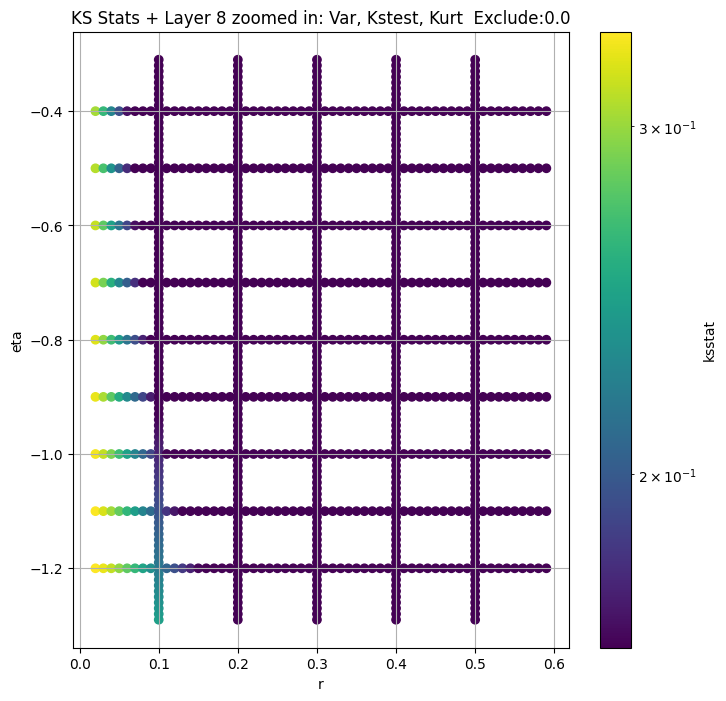

Layer 9


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.20730999999999977, var: 0.08550621569156647


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.20730999999999977, var: 0.08715991675853729


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.20730999999999977, var: 0.08904165774583817


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.20730999999999977, var: 0.09130848944187164


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.20730999999999977, var: 0.09492339938879013
Number of samples: 100000, Without approximation : 32866304.0


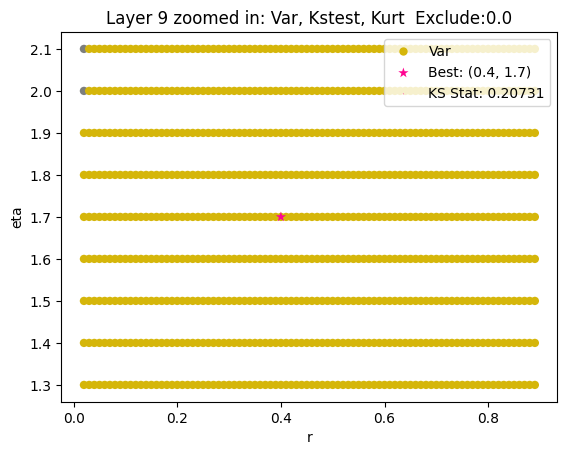

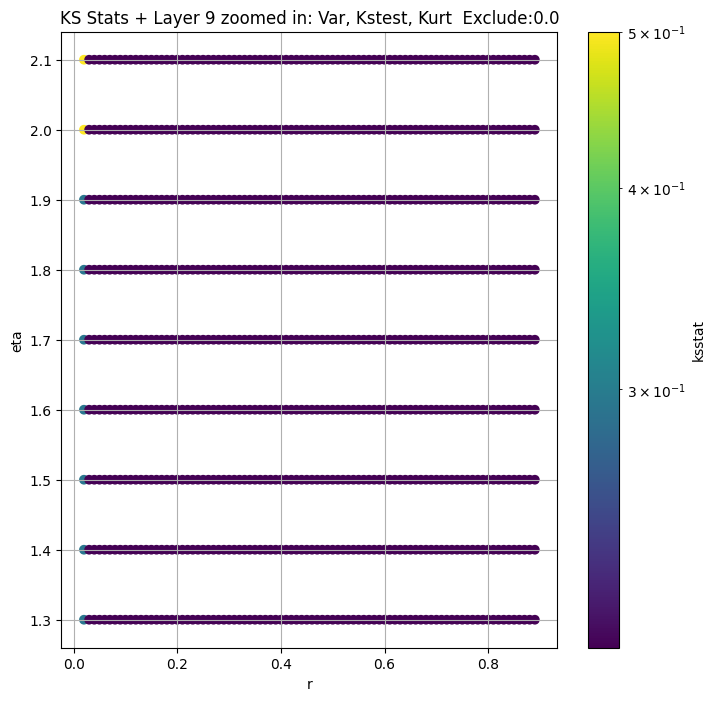

Not a fit


obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1275.482800  1122.617700  1438.783600   2.691186    1.650079   
3       278.655100   260.725000   297.130300   3.187759    2.693464   
4        59.196210    55.125656    63.416320   5.437293    4.557088   
5        11.759620    10.812905    12.747702   8.242884    6.854574   
6         2.387361     2.172065     2.619214  11.316391    9.004839   
7         0.550675     0.498310     0.607436  12.836428    9.904830   
8         0.193843     0.175944     0.213105  11.674941    8.750526   
9         0.094923     0.086730     0.103822  10.211844    7.322517   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.078578         2006.0             0.010003        1.4         -0.7   
3        3.752663         8024.0             0.014406        1.3         -1.0   
4        6.545280        32096.0             0.018725        4.0         -1.2   
5       10.175736       128384.0             0.039870        1.9         -1.3   
6       14.718013       513536.0             0.077180        1.4         -1.2   
7       17.388290      2054144.0             0.120740        1.1         -1.3   
8       17.741255      8216576.0             0.163380        0.1         -0.8   
9       15.754383     32866304.0             0.207310        0.4          1.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       2.209447e+03                     0.0         1275.482788   
3       6.906262e+02                     0.0          278.655090   
4       2.760058e+02                     0.0           59.196210   
5       7.462944e+01                     0.0           11.759620   
6       9.734533e+00                     0.0            2.156558   
7       2.927620e+00                     0.0            0.550675   
8       6.670561e-12                     0.0            0.193843   
9       4.221504e-04                     0.0            0.094923   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.030238          0.009599     1.4     -0.71   
3                     0.015140          0.013727     1.7     -1.03   
4                     0.007575          0.018725     4.0     -1.20   
5                     0.003789          0.039870     1.9     -1.30   
6                     0.001895          0.077180     1.8     -1.23   
7                     0.000947          0.120740     1.1     -1.30   
8                     0.000474          0.163380     0.1     -0.80   
9                     0.000237          0.207310     0.4      1.70   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      2.232821e+03                  0.0        19272  
3      8.267531e+02                  0.0        10155  
4      2.760058e+02                  0.0         5076  
5      7.462944e+01                  0.0         1128  
6      1.040404e+01                100.0          315  
7      2.927620e+00                  0.0          125  
8      6.670561e-12                  0.0           69  
9      4.221504e-04                  0.0           -1

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

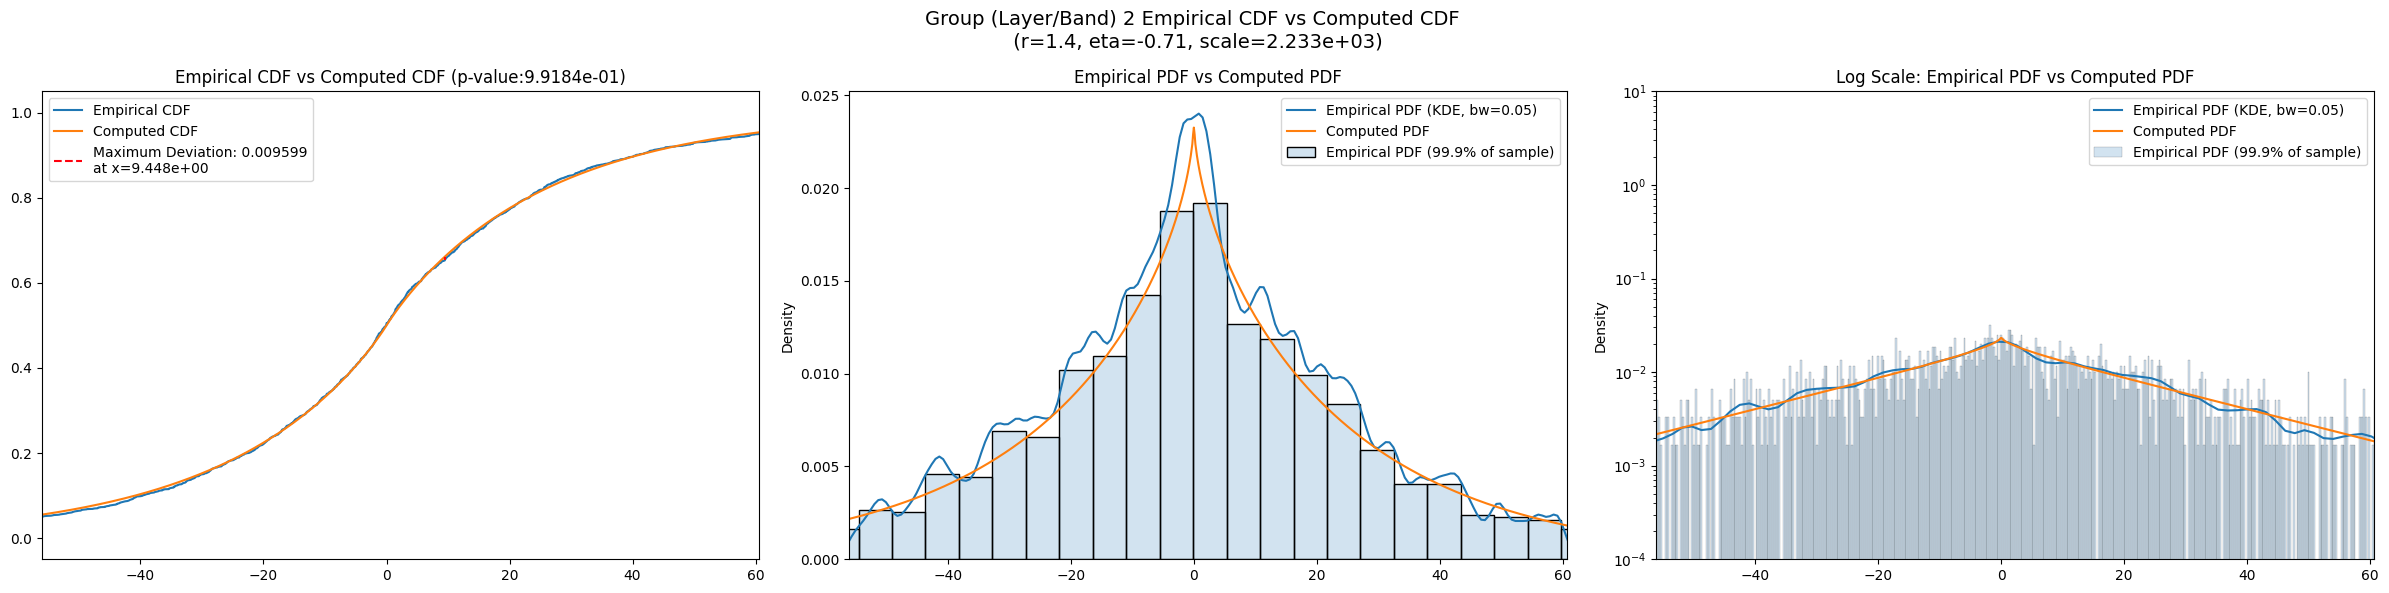

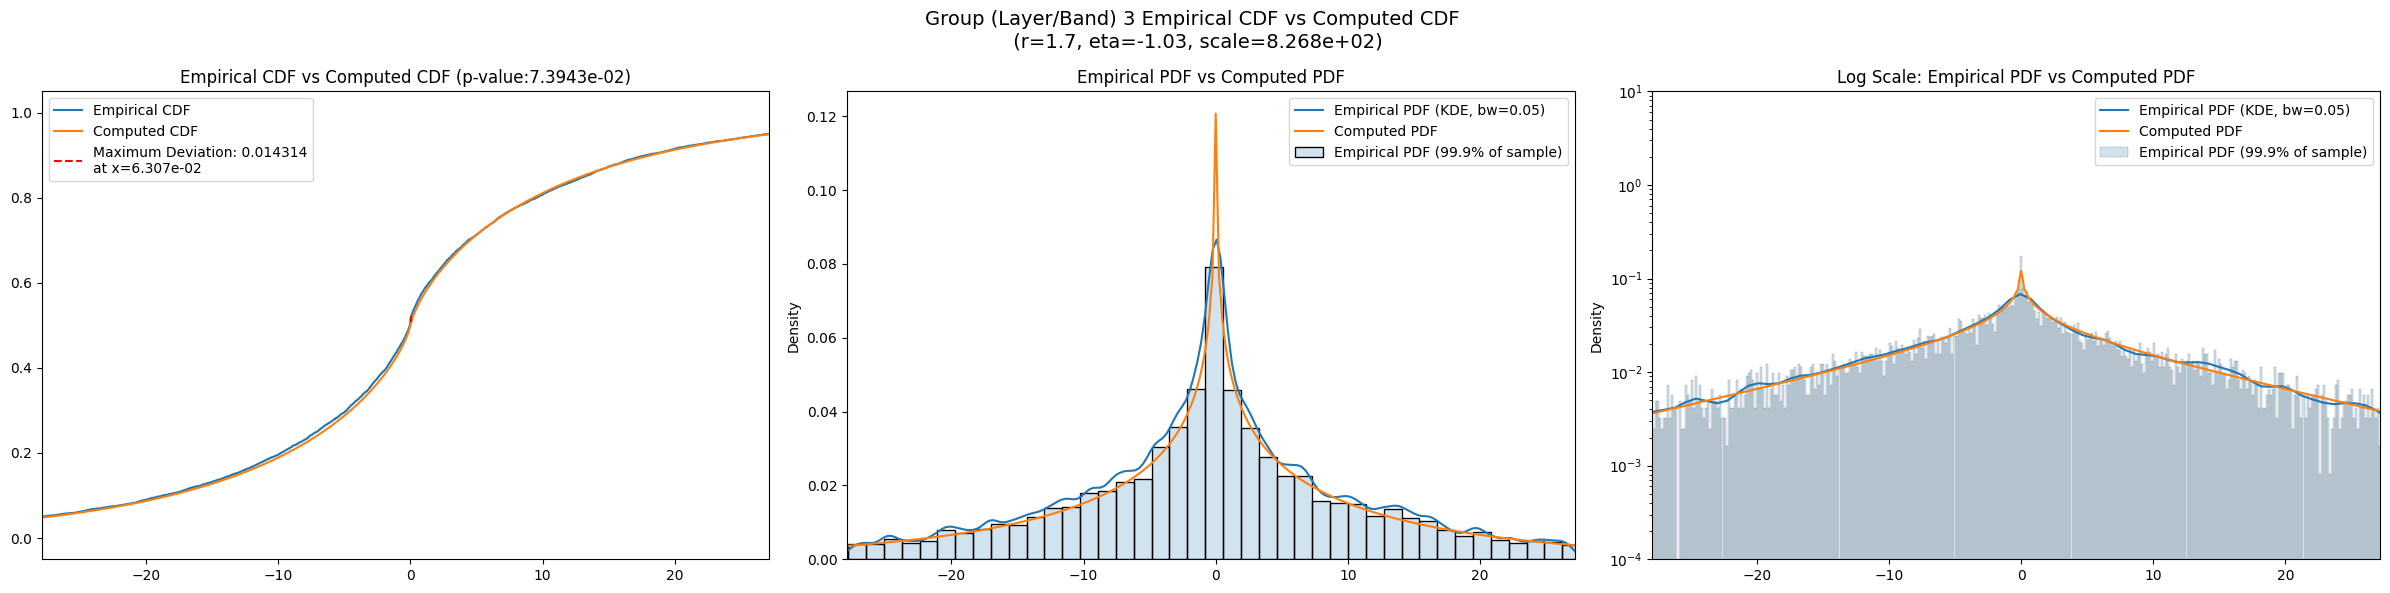

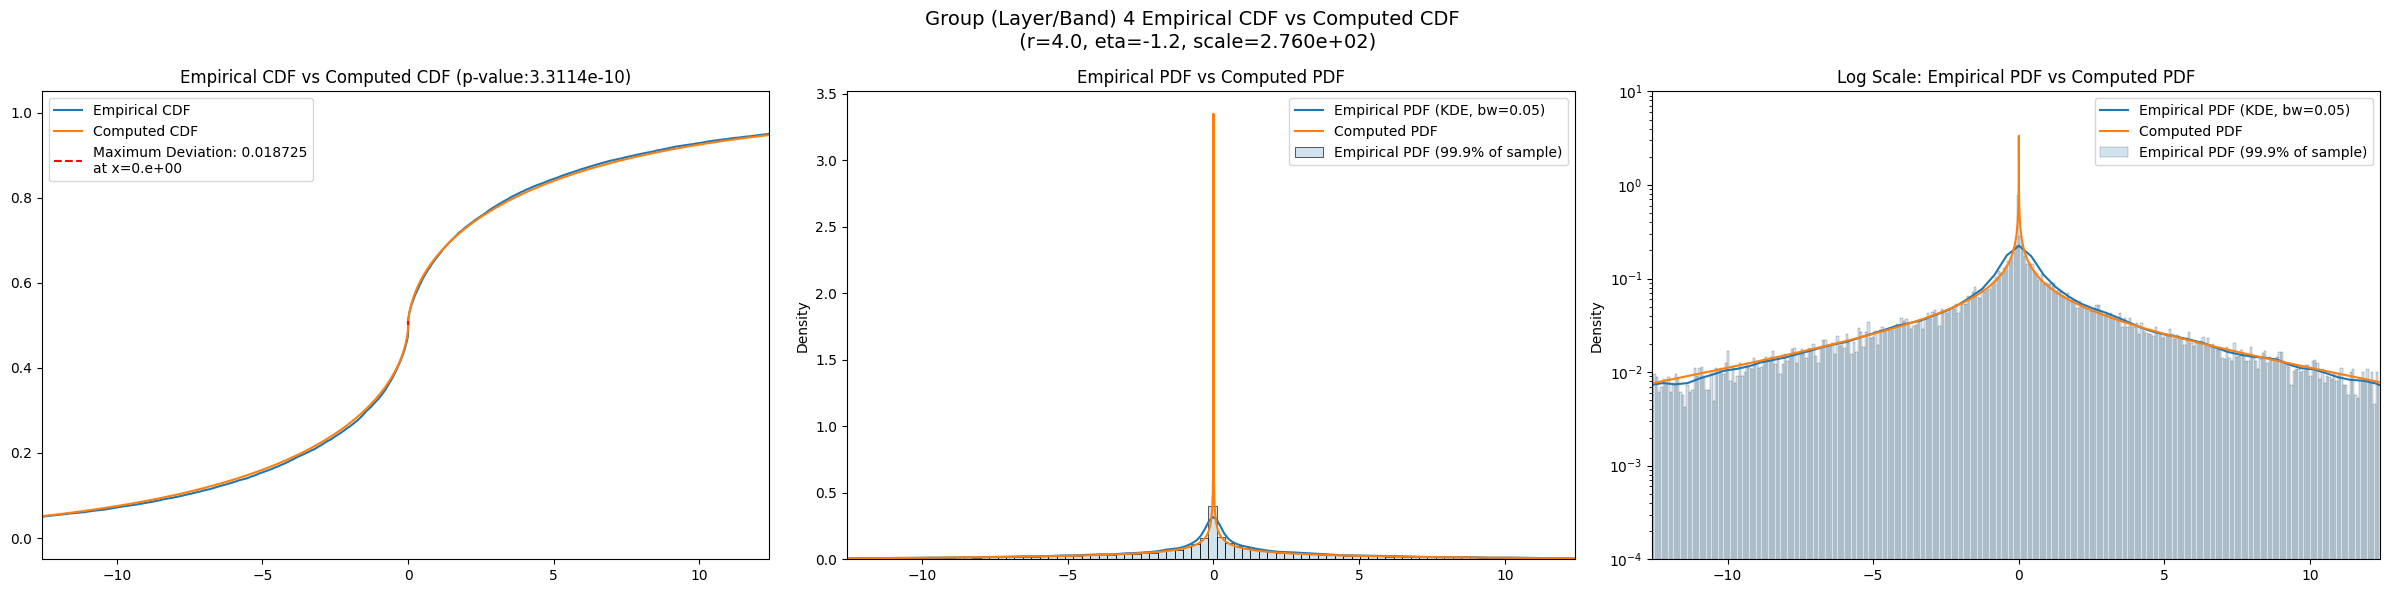

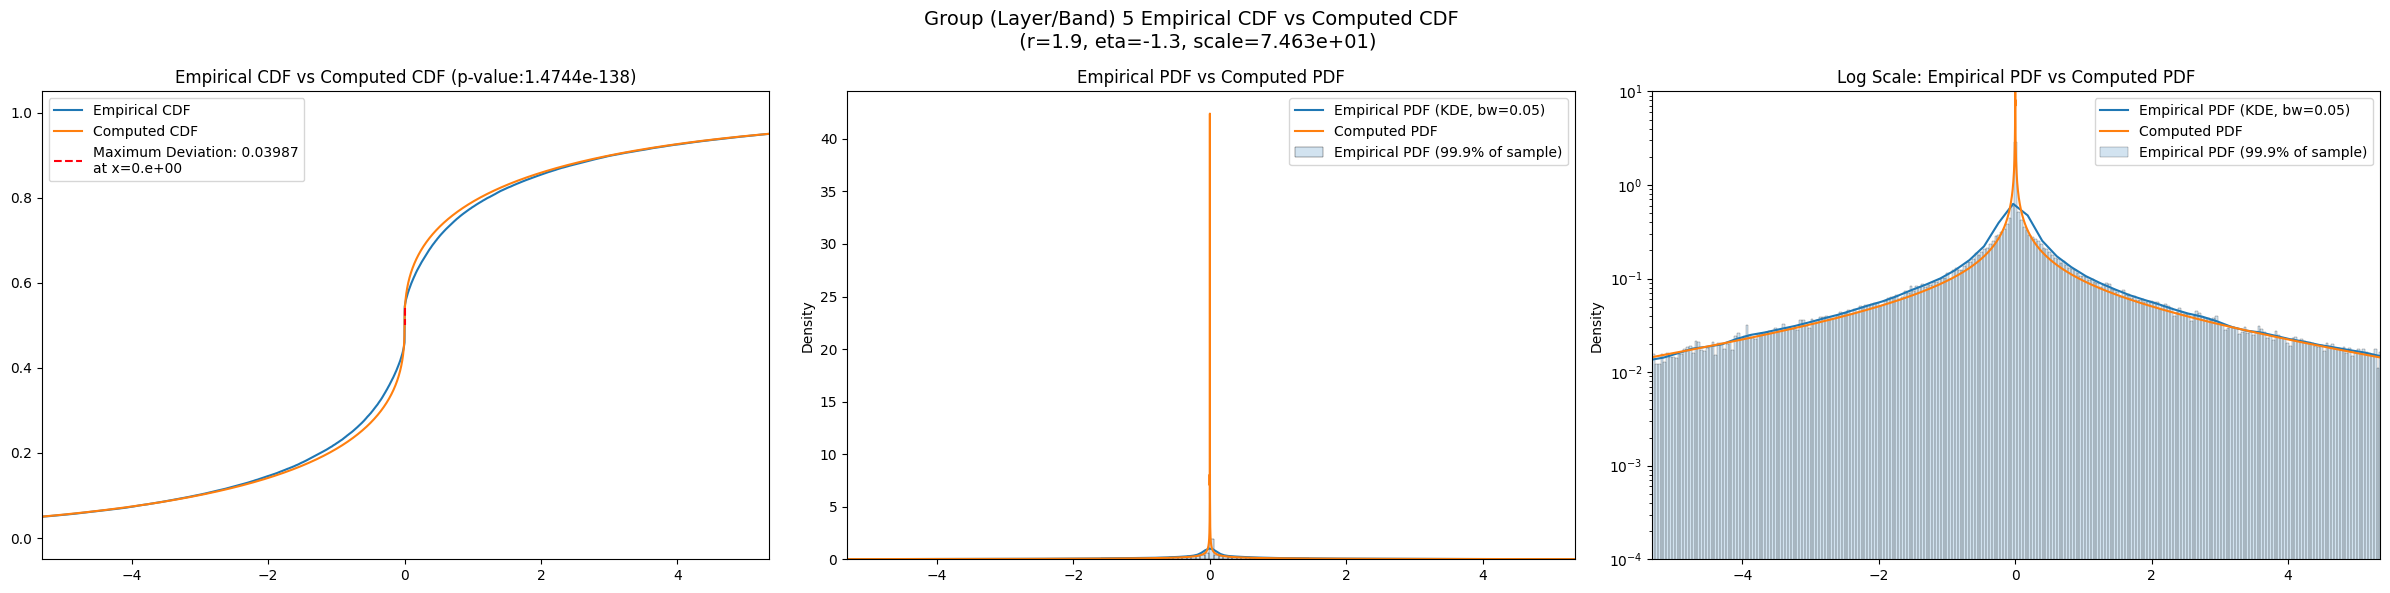

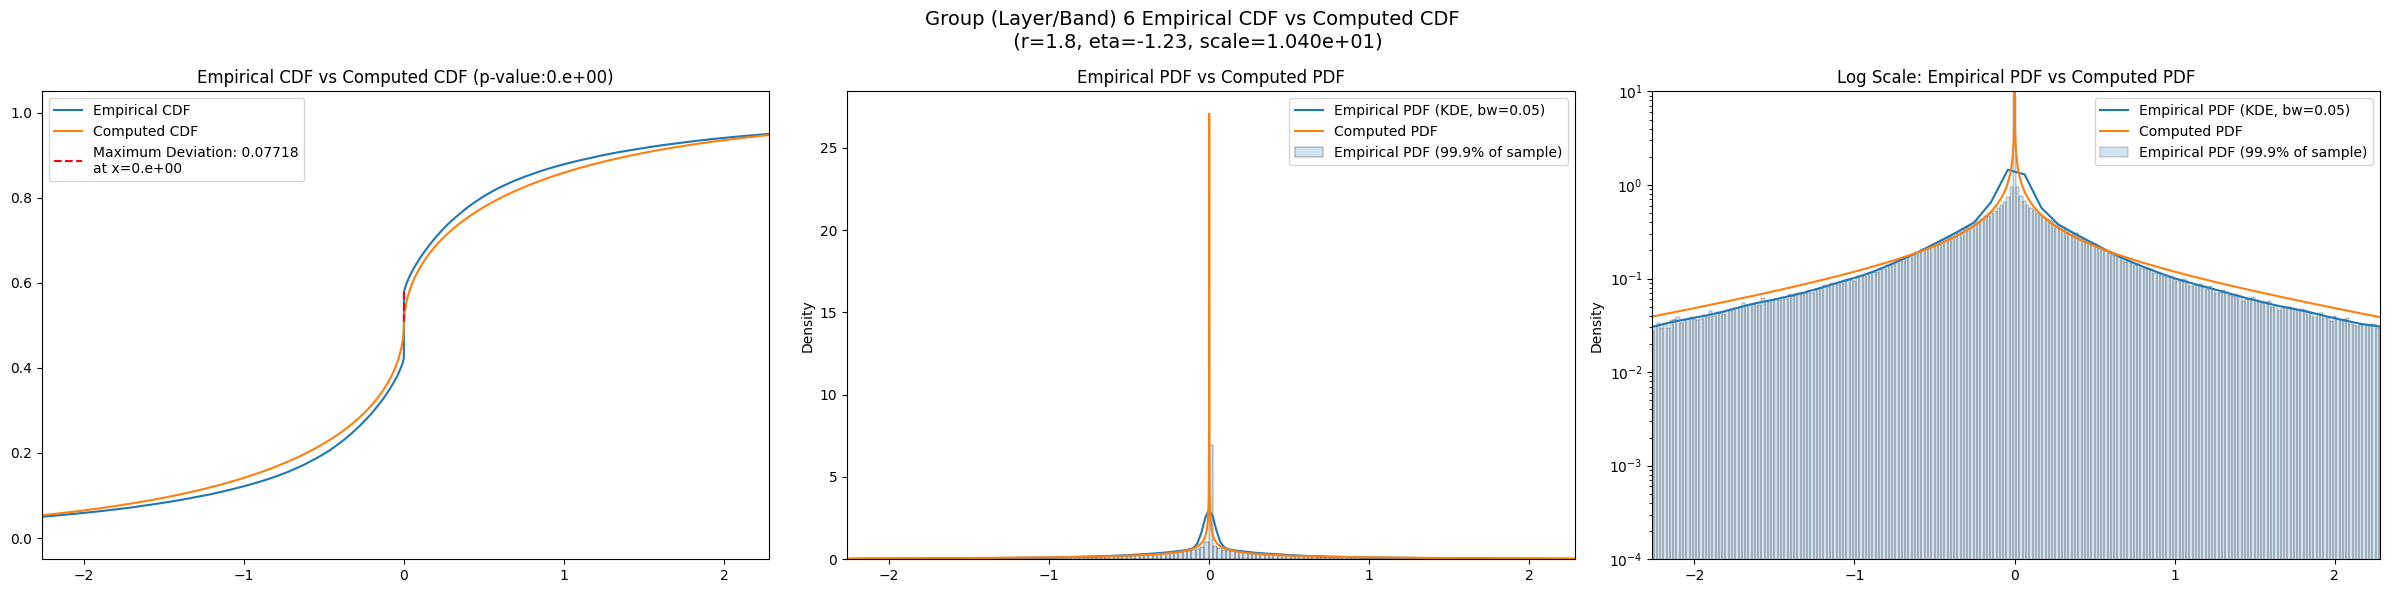

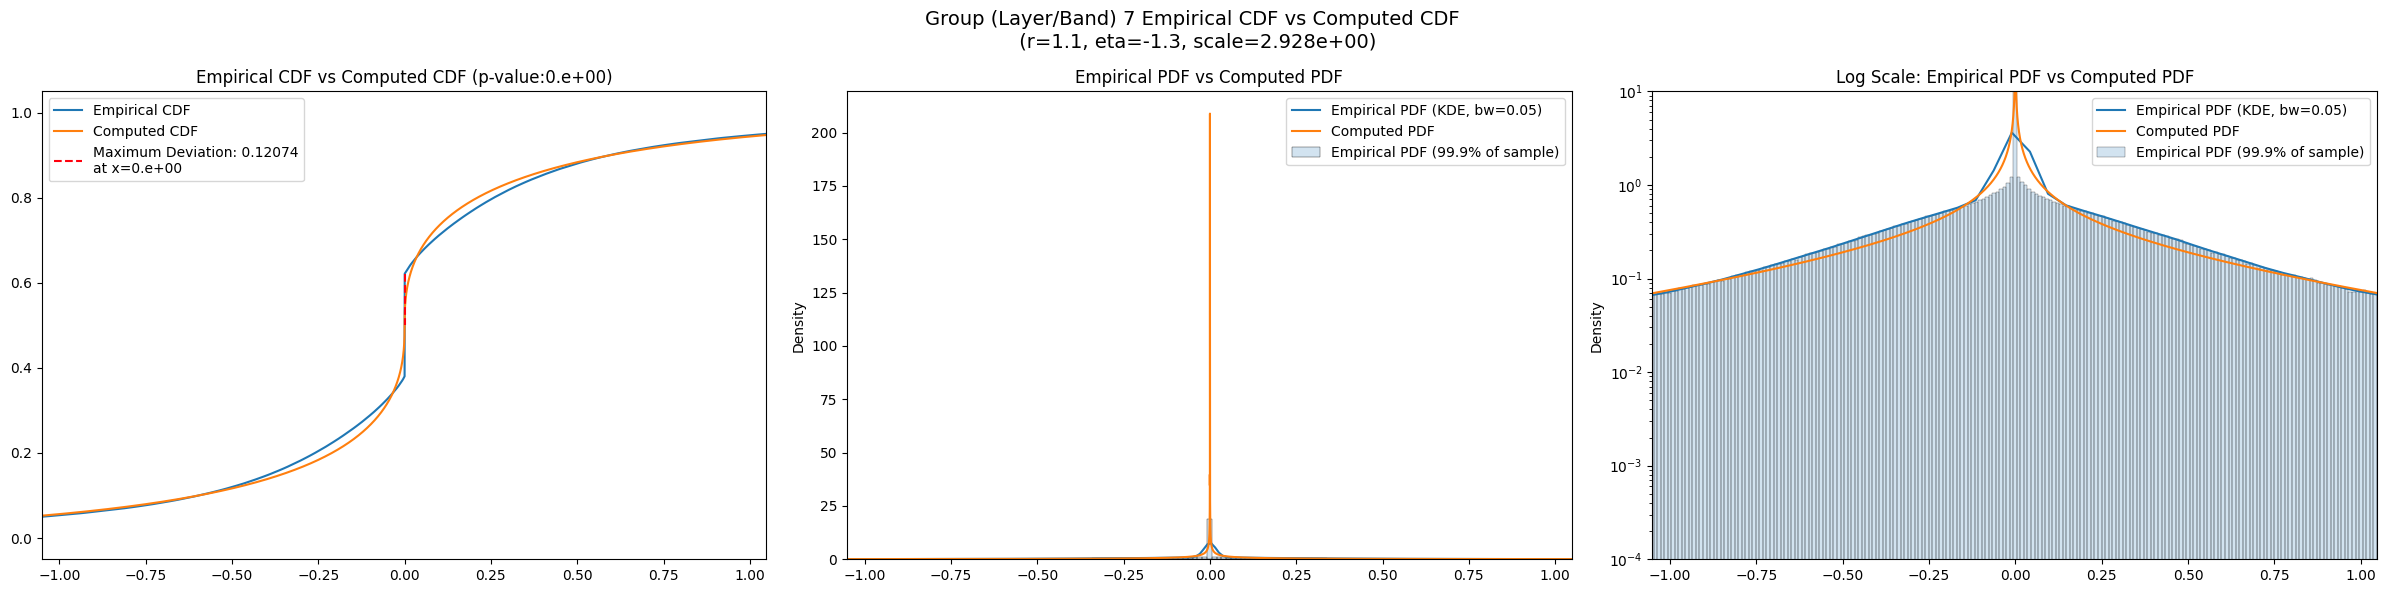

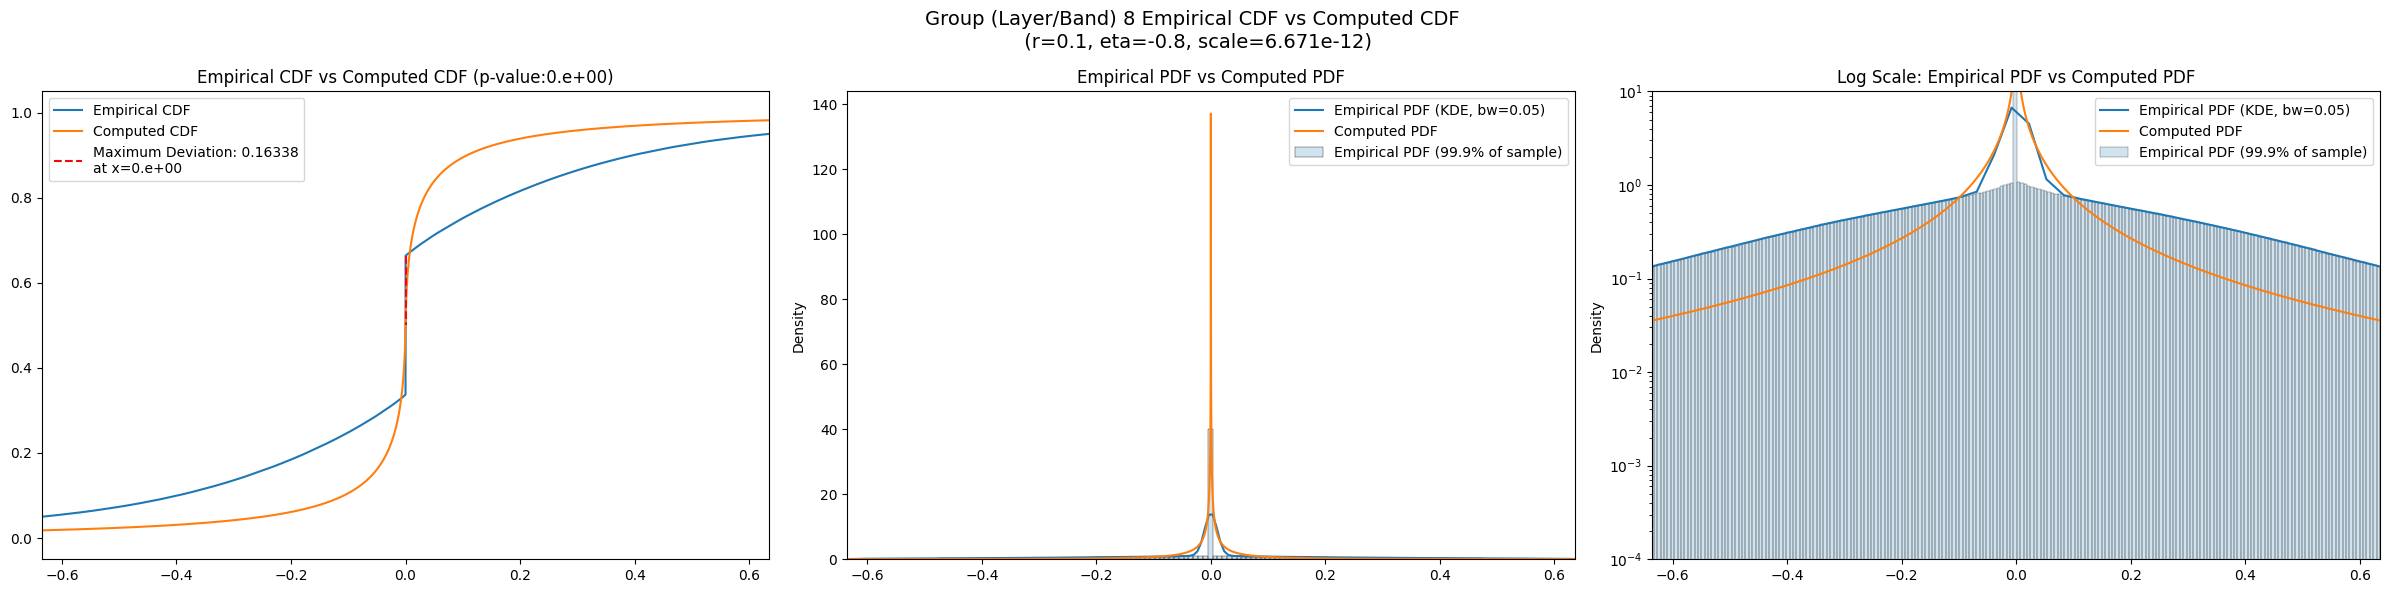

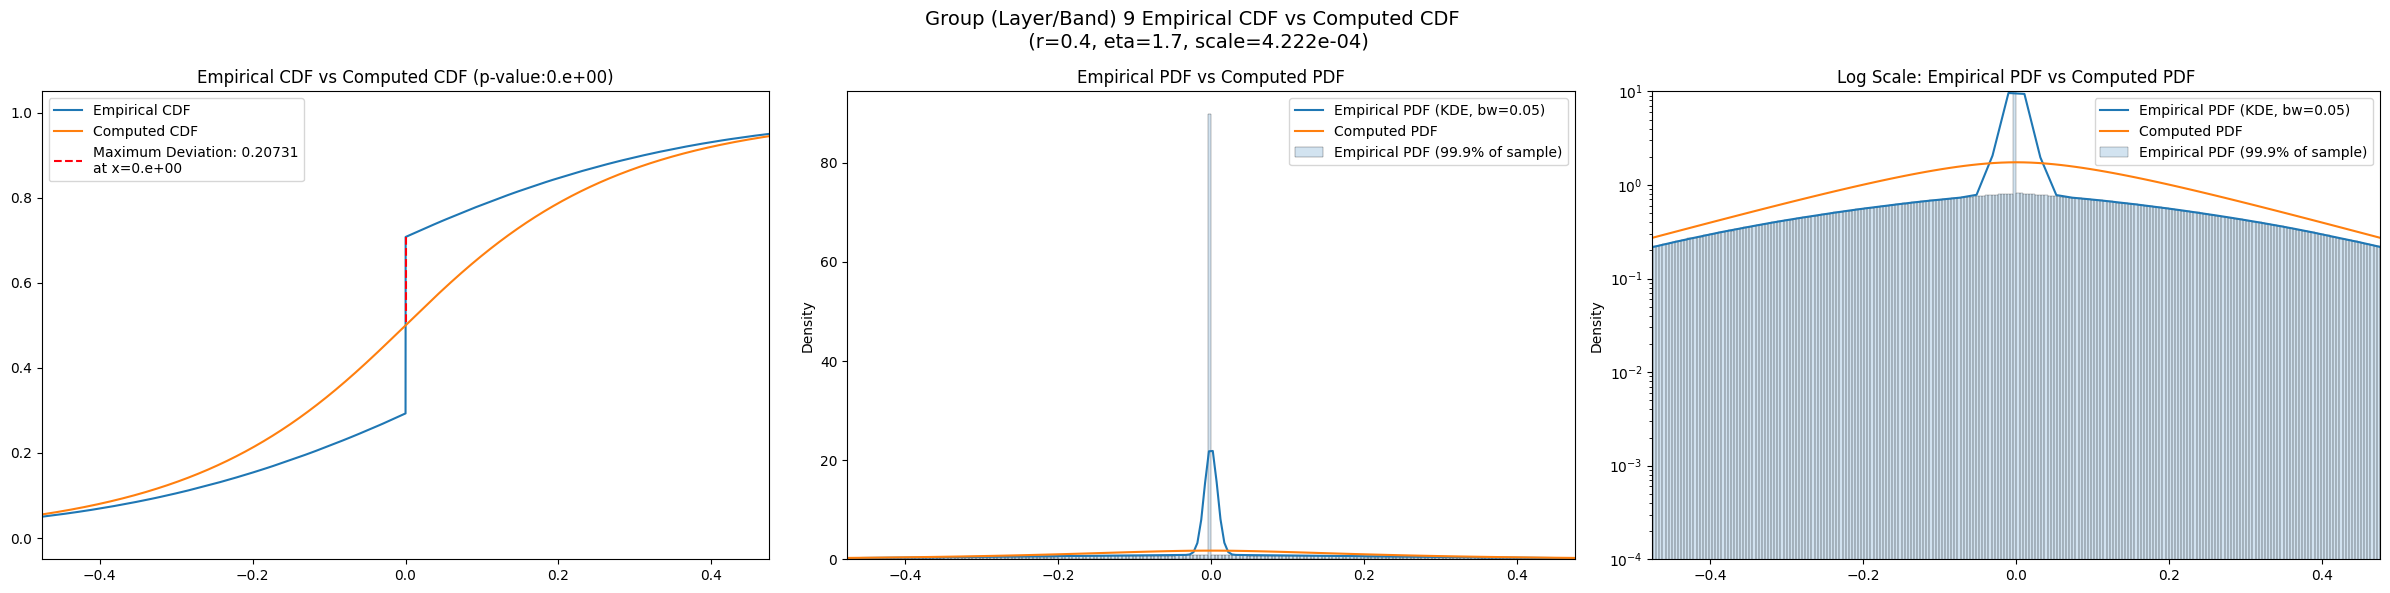

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1275.482800  1122.617700  1438.783600   2.691186    1.650079   
3       278.655100   260.725000   297.130300   3.187759    2.693464   
4        59.196210    55.125656    63.416320   5.437293    4.557088   
5        11.759620    10.812905    12.747702   8.242884    6.854574   
6         2.387361     2.172065     2.619214  11.316391    9.004839   
7         0.550675     0.498310     0.607436  12.836428    9.904830   
8         0.193843     0.175944     0.213105  11.674941    8.750526   
9         0.094923     0.086730     0.103822  10.211844    7.322517   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.078578         2006.0             0.010003        1.4         -0.7   
3        3.752663         8024.0             0.014406        1.3         -1.0   
4        6.545280        32096.0             0.018725        4.0         -1.2   
5       10.175736       128384.0             0.039870        1.9         -1.3   
6       14.718013       513536.0             0.077180        1.4         -1.2   
7       17.388290      2054144.0             0.120740        1.1         -1.3   
8       17.741255      8216576.0             0.163380        0.1         -0.8   
9       15.754383     32866304.0             0.207310        0.4          1.7   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       29.111300              0.035569          1.218920e-02   
3      ...       11.168900              0.054804          2.180660e-21   
4      ...        4.018750              0.074485         2.640220e-155   
5      ...        1.471190              0.081769          0.000000e+00   
6      ...        0.552538              0.089585          0.000000e+00   
7      ...        0.222424              0.120740          0.000000e+00   
8      ...        0.098767              0.163385          0.000000e+00   
9      ...        0.126888              0.207310          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          24.421600             0.012313         9.175770e-01  20.067500   
3           9.446040             0.032357         9.845810e-08   7.755950   
4           3.391070             0.050498         1.435920e-71   2.711970   
5           1.221320             0.059910         0.000000e+00   0.952401   
6           0.407748             0.079124         0.000000e+00   0.320122   
7           0.304585             0.120740         0.000000e+00   0.205309   
8           0.066717             0.163380         0.000000e+00   0.052127   
9           0.181671             0.207310         0.000000e+00   0.113213   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.017848   5.391350e-01          9.918375e-01  
3           0.037473   3.164440e-10          9.632221e-02  
4           0.054402   5.304060e-83          3.311414e-10  
5           0.062369   0.000000e+00         9.210554e-178  
6           0.080170   0.000000e+00          0.000000e+00  
7           0.120740   0.000000e+00          0.000000e+00  
8           0.163381   0.000000e+00          0.000000e+00  
9           0.207310   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.010003                 0.030238          0.009599   
3                 0.014406                 0.015140          0.013727   
4                 0.018725                 0.007575          0.018725   
5                 0.039870                 0.003789          0.039870   
6                 0.077180                 0.001895          0.077180   
7                 0.120740                 0.000947          0.120740   
8                 0.163380                 0.000474          0.163380   
9                 0.207310                 0.000237          0.207310   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.035569             0.012313       0.017848  
3                  0.054804             0.032357       0.037473  
4                  0.074485             0.050498       0.054402  
5                  0.081769             0.059910       0.062369  
6                  0.089585             0.079124       0.080170  
7                  0.120740             0.120740       0.120740  
8                  0.163385             0.163380       0.163381  
9                  0.207310             0.207310       0.207310

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             1275.482788          0.009599     1.4     -0.71  2.232821e+03   
3              278.655090          0.013727     1.7     -1.03  8.267531e+02   
4               59.196210          0.018725     4.0     -1.20  2.760058e+02   
5               11.759620          0.039870     1.9     -1.30  7.462944e+01   
6                2.156558          0.077180     1.8     -1.23  1.040404e+01   
7                0.550675          0.120740     1.1     -1.30  2.927620e+00   
8                0.193843          0.163380     0.1     -0.80  6.670561e-12   
9                0.094923          0.207310     0.4      1.70  4.221504e-04   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                    100.0  
7                      0.0  
8                      0.0  
9                      0.0

In [21]:
eng.quit()